# Theory:

Discrete Update equations for RC:
$$
r_{i+1} = (1-\alpha) r_{i} + \alpha\tanh(W_{in} x_i + W r_i)
$$

Continuous Update equations for RC:
$$
\dot{r} = \gamma [-r + \tanh(W_{in}x + W r)] \\
$$

.. with explicit Euler:
$$
r_{i+1} = r_i + dt \gamma [-r_i + \tanh(W_{in}x_i + W r_i)] \\
r_{i+1} = (1-dt\gamma) r_i + dt\gamma\tanh(W_{in}x_i + W r_i)
$$

Time series described by an ODE:

$$
\dot{r} = f(r)
$$

... with explicit Euler:

$$
r_{i+1} = r_i + dt f(r_i)
$$

Two options to couple the ODE with the input:

1. Option: Couple on discrete update level - shift previous point:
$$
r_{i+1} = (W_{in} x_i + r_i) + dt f(W_{in} x_i + r_i)
$$
2. Option: Couple on discrete update level - shift the point only for the force:
$$
r_{i+1} = r_i + dt f(W_{in} x_i + r_i)
$$

3. Option: Couple on ODE level:
$$
\dot{r} = f(r) + W_{in} x \\
r_{i+1} = r_i + dt [f(r_i) + W_{in}x_i]
$$

# Imports:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

# new imports:
import rescomp.lyapunov_analysis as la

# Lorenz iterator:

In [2]:
# Lorenz parameters:
dt_L = 0.01
starting_point_L = np.array([0, 1, 0])

In [3]:
# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

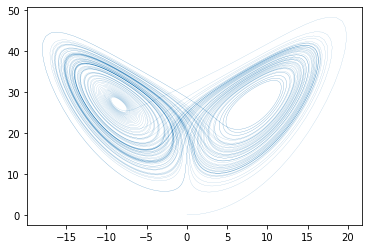

In [4]:
# test lorenz iterator:
time_steps = 10000

results = np.zeros((time_steps, 3))
results[0, :] = starting_point_L
for i in range(1, time_steps):
    x_last = results[i - 1, :]
    results[i, :] = f_L(x_last)

plt.plot(results[:, 0], results[:, 2], linewidth=0.1)

# Lorenz 96 Iterator:

### Plotting the pure Lorenz 96 system

In [5]:
# Lorenz 96 parameters:
dt_L96 = 0.005
dims = 500
np.random.seed(1)
starting_point_L96 = np.random.randn(dims)

In [6]:
# Lorenz96 iterator:

_lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta
f_L96 = lambda x: iterator(_lorenz_96, dt_L96, x)

(0, 50)

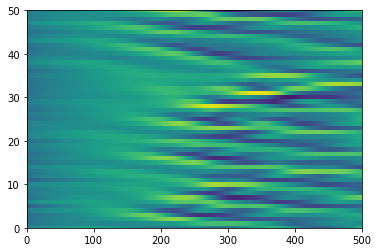

In [10]:
time_steps_L96 = 500
results_L96 = np.zeros((time_steps_L96, dims))

results_L96[0, :] = starting_point_L96
for i in range(1, time_steps_L96):
    x_last = results_L96[i - 1, :]
    results_L96[i, :] = f_L96(x_last)

plt.imshow(results_L96.T, aspect="auto")
plt.xlim(0, 500)
plt.ylim(0, 50)

# Couplings:

In [386]:
# Parameters:
time_steps = 10000
disc_timesteps = 100

# test iterator:
w_in_scale = 0.5
np.random.seed(2)
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))

# take every nth reservoir value:
nth = 1

In [310]:
starting_point_L96_use = starting_point_L96
starting_point_L_use = starting_point_L

# discard the starting timesteps:
for i in range(disc_timesteps):
    starting_point_L96_use = f_L96(starting_point_L96_use)
    starting_point_L_use = f_L(starting_point_L_use)

In [311]:
# L96
results_L96 = np.zeros((time_steps, dims))
results_L96[0, :] = starting_point_L96_use

# L96 coupled
results_L96_coupled = results_L96.copy()

# L:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = starting_point_L_use

## 1. Option: Iterator based coupling - shift previous point:

In [265]:
for i in range(1, time_steps):

    # previous values:
    x_last_base = results_L96[i - 1, :]
    x_last_res = results_L96_coupled[i - 1, :]
    x_last_in = results_L[i - 1, :]

    x_add = w_in.dot(x_last_in)
    for k in range(nth):
        x_last_base = f_L96(x_last_base)
        # inp = x_last_res + x_add
        inp = np.tanh(x_last_res + x_add)
        x_last_res = f_L96(inp)

    # updates iteration:
    results_L96[i, :] = x_last_base
    results_L96_coupled[i, :] = x_last_res
    results_L[i, :] = f_L(x_last_in)

## 2. Option: Iterator based coupling - only shift force:

In [168]:
for i in range(1, time_steps):

    # previous values:
    x_last_base = results_L96[i - 1, :]
    x_last_res = results_L96_coupled[i - 1, :]
    x_last_in = results_L[i - 1, :]

    x_add = w_in.dot(x_last_in)
    for k in range(nth):
        x_last_base = _lorenz_96(x_last_base)*dt_L96 + x_last_base
        inp = x_last_res + x_add
        x_last_res = _lorenz_96(inp)*dt_L96 + results_L96_coupled[i - 1, :]

    # updates iteration:
    results_L96[i, :] = x_last_base
    results_L96_coupled[i, :] = x_last_res
    results_L[i, :] = f_L(x_last_in)

## 3. Option: ODE based coupling:

In [312]:
# Coupled ODE:
_lorenz_96_coupled = lambda r, x: _lorenz_96(r) + w_in.dot(x)

In [313]:
for i in range(1, time_steps):

    # previous values:
    x_last_base = results_L96[i - 1, :]
    x_last_res = results_L96_coupled[i - 1, :]
    x_last_in = results_L[i - 1, :]

    for k in range(nth):
        x_last_base = _lorenz_96(x_last_base)*dt_L96 + x_last_base
        x_last_res = _lorenz_96_coupled(x_last_res, x_last_in)*dt_L96 + x_last_res

    # updates iteration:
    results_L96[i, :] = x_last_base
    results_L96_coupled[i, :] = x_last_res
    results_L[i, :] = f_L(x_last_in)

## Plotting:

Text(0.5, 1.0, 'L96 coupled - L96')

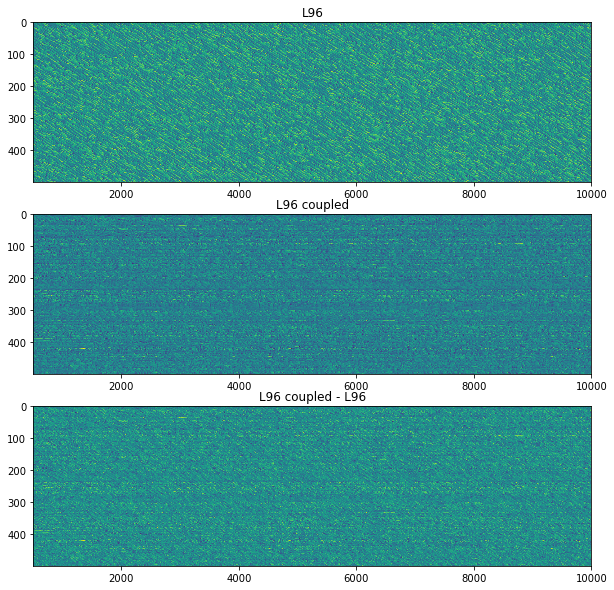

In [314]:
xlim = (500,10000)
# xlim = None

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

ax = axs[0]
ax.imshow(results_L96.T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96")

ax = axs[1]
ax.imshow(results_L96_coupled.T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96 coupled")

ax = axs[2]
ax.imshow((results_L96_coupled - results_L96).T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96 coupled - L96")

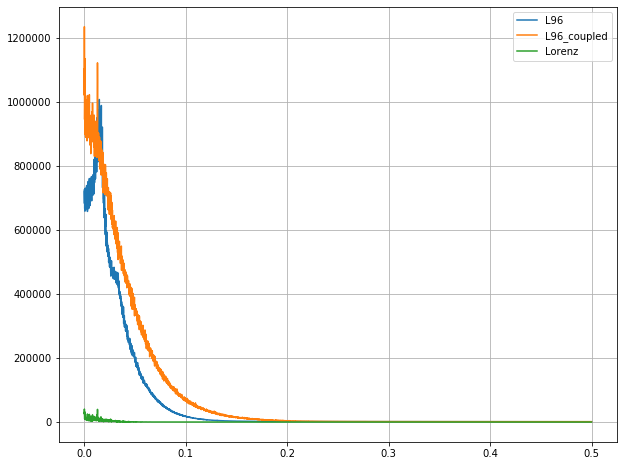

In [315]:
# Explore frequencies:
plt.figure(figsize=(10, 8))

x, y = rescomp.measures.fourier_spectrum(results_L96)
plt.plot(x, y, label="L96")

x, y = rescomp.measures.fourier_spectrum(results_L96_coupled)
plt.plot(x, y, label="L96_coupled")

x, y = rescomp.measures.fourier_spectrum(results_L)
plt.plot(x, y, label="Lorenz")

plt.grid()
plt.legend()
# plt.xlim(-0.05, 0.1)

## Train and Test:

In [316]:
results_L.shape

(10000, 3)

In [317]:
# Try to fit the coupled to the output:
sync_steps = 500
train_steps = 9000
test_steps = 500

x_sync = results_L96_coupled[: sync_steps, :]
y_sync = results_L[: sync_steps, :]

x_train = results_L96_coupled[sync_steps: sync_steps + train_steps, :]
y_train = results_L[sync_steps: sync_steps + train_steps, :]

x_test = results_L96_coupled[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
y_test = results_L[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

x_test.shape

(500, 500)

In [341]:
# Train:
from sklearn.linear_model import Ridge, LogisticRegression

model = Ridge(alpha=1)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_test_pred

array([[ 1.13765295,  7.53462203, 32.18469739],
       [ 1.90565577,  8.96168412, 33.9385244 ],
       [ 2.64406277, 10.403148  , 35.25866986],
       ...,
       [ 8.21549307,  4.76362325, 15.69142716],
       [ 9.05973391,  6.22879738, 15.85657414],
       [ 9.83773532,  7.8008389 , 15.91644192]])

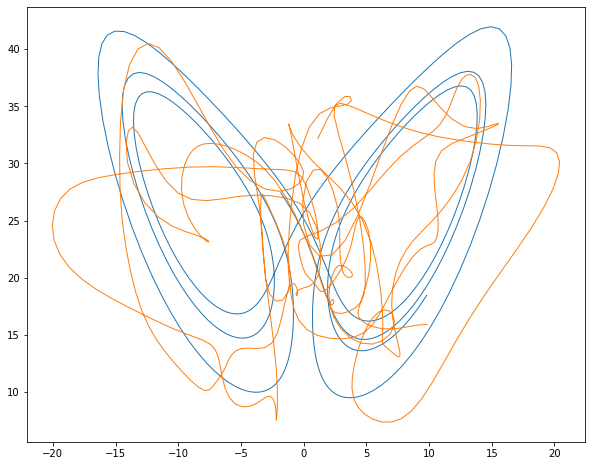

In [324]:
plt.figure(figsize=(10, 8))

plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1)
plt.plot(y_test_pred[:, 0], y_test_pred[:, 2], linewidth=1)

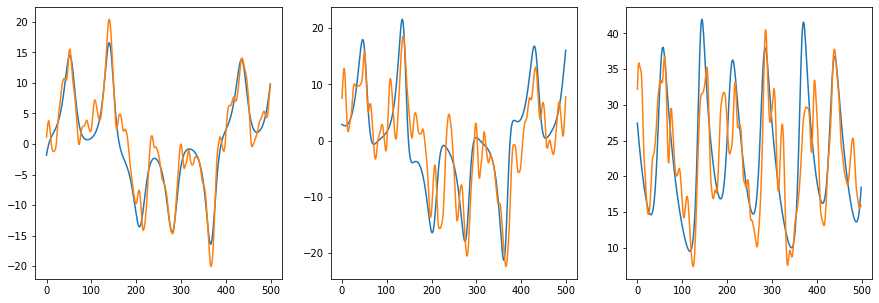

In [325]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axs[i]
    ax.plot(y_test[:, i])
    ax.plot(y_test_pred[:, i])

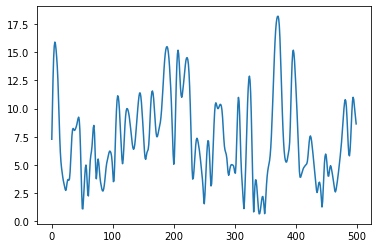

In [326]:
error = np.linalg.norm(y_test_pred - y_test, axis=1)
plt.plot(error)

# Comparison normal RC:

In [507]:
import networkx as nx

alpha = 1

# np.random.seed(1)
# W = np.random.randn(dims, dims)
edge_prob = 0.01
W = nx.to_numpy_array(nx.fast_gnp_random_graph(dims, edge_prob,seed=np.random))

(array([247476.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,   2524.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

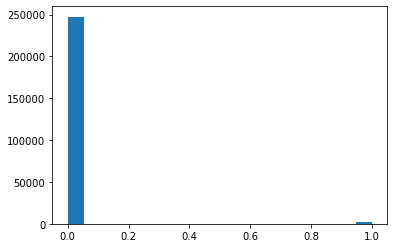

In [508]:
plt.hist(W.flatten(), bins="auto")

In [509]:
# pure reservoir:
results_res_nc = np.zeros((time_steps, dims))
results_res_nc[0, :] = starting_point_L96_use

# res
results_res = np.zeros((time_steps, dims))
results_res[0, :] = starting_point_L96_use

# L:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = starting_point_L_use

In [601]:
f = lambda x: np.tanh(0.1*x)
f = lambda x: 0.1*x
# f = lambda x: np.heaviside(x,1)
# f = lambda x: 1/(1+np.exp(-x))

for i in range(1, time_steps):

    # previous values:
    x_last_res_nc = results_res_nc[i - 1, :]
    x_last_res = results_res[i - 1, :]
    x_last_in = results_L[i - 1, :]

    x_add = w_in.dot(x_last_in)
    for k in range(nth):
        inp = x_last_res + x_add
        x_last_res = (1-alpha)*x_last_res + alpha*f(W.dot(x_last_res) + x_add)
        x_last_res_nc = (1-alpha)*x_last_res_nc + alpha*f(W.dot(x_last_res_nc))

    # updates iteration:
    results_res_nc[i, :] = x_last_res_nc
    results_res[i, :] = x_last_res
    results_L[i, :] = f_L(x_last_in)

(array([4.00000e+00, 9.00000e+00, 1.70000e+01, 4.70000e+01, 5.50000e+01,
        7.50000e+01, 9.30000e+01, 1.60000e+02, 2.45000e+02, 3.55000e+02,
        6.39000e+02, 9.95000e+02, 1.55400e+03, 2.48200e+03, 3.47200e+03,
        4.98000e+03, 6.71600e+03, 8.67700e+03, 1.12100e+04, 1.41930e+04,
        1.79510e+04, 2.20660e+04, 2.75390e+04, 3.33390e+04, 3.98770e+04,
        4.80380e+04, 5.68220e+04, 6.81390e+04, 8.09550e+04, 9.33700e+04,
        1.06458e+05, 1.23963e+05, 1.44597e+05, 1.61432e+05, 1.75961e+05,
        1.96555e+05, 2.09310e+05, 2.19401e+05, 2.19800e+05, 2.12898e+05,
        1.89291e+05, 2.19754e+05, 2.30342e+05, 2.12244e+05, 1.96551e+05,
        1.82696e+05, 1.76536e+05, 1.70498e+05, 1.57273e+05, 1.41579e+05,
        1.25697e+05, 1.09009e+05, 9.40050e+04, 8.21250e+04, 7.11300e+04,
        6.12360e+04, 5.07850e+04, 4.24110e+04, 3.49380e+04, 2.81540e+04,
        2.26720e+04, 1.80440e+04, 1.42560e+04, 1.15150e+04, 9.03500e+03,
        7.38800e+03, 6.09300e+03, 5.03800e+03, 3.96

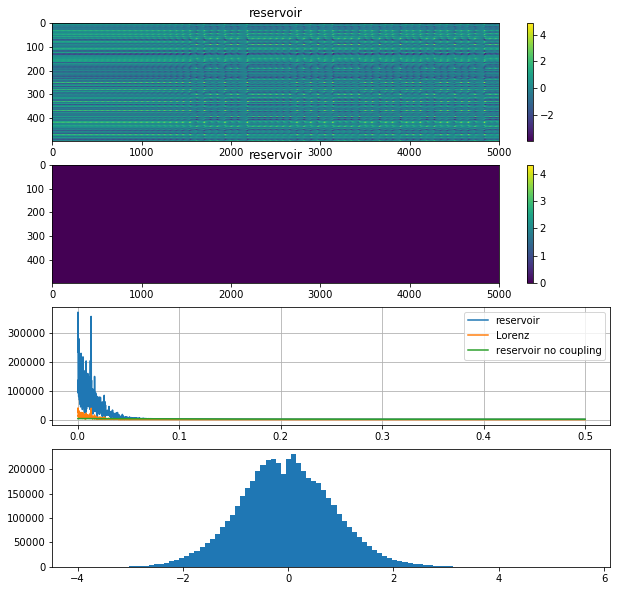

In [602]:
xlim = (0,5000)
# xlim = None

fig, axs = plt.subplots(4, 1, figsize=(10, 10))

ax = axs[0]
im = ax.imshow(results_res[1:, :].T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("reservoir")
fig.colorbar(im, ax=ax, orientation='vertical')

ax = axs[1]
im = ax.imshow(results_res_nc[1:, :].T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("reservoir")
fig.colorbar(im, ax=ax, orientation='vertical')

ax = axs[2]
x, y = rescomp.measures.fourier_spectrum(results_res)
ax.plot(x, y, label="reservoir")
x, y = rescomp.measures.fourier_spectrum(results_L)
ax.plot(x, y, label="Lorenz")
x, y = rescomp.measures.fourier_spectrum(results_res_nc)
ax.plot(x, y, label="reservoir no coupling")

ax.grid()
ax.legend()

ax = axs[3]
ax.hist(results_res.flatten(), bins=100)

In [603]:
# Try to fit the coupled to the output:
sync_steps = 500
train_steps = 1000
test_steps = 4500

x_sync = results_res[: sync_steps, :]
y_sync = results_L[: sync_steps, :]

x_train = results_res[sync_steps: sync_steps + train_steps, :]
y_train = results_L[sync_steps: sync_steps + train_steps, :]

x_test = results_res[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
y_test = results_L[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

# Train:
from sklearn.linear_model import Ridge, LogisticRegression

model = Ridge(alpha=0.005)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_test_pred

array([[-1.33809221, -1.32381334, 18.05226157],
       [-1.34391654, -1.45052796, 17.59390604],
       [-1.36110226, -1.58353846, 17.14984038],
       ...,
       [-3.65370126, -6.87481034,  9.78180788],
       [-3.98183842, -7.49442882,  9.79713201],
       [-4.34073068, -8.16727117,  9.86260056]])

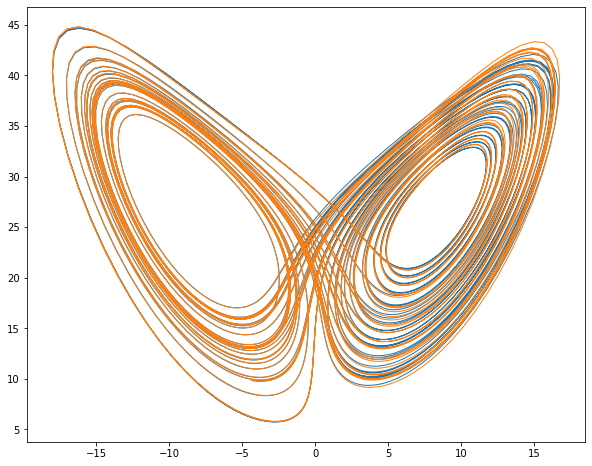

In [604]:
plt.figure(figsize=(10, 8))

plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1)
plt.plot(y_test_pred[:, 0], y_test_pred[:, 2], linewidth=1)

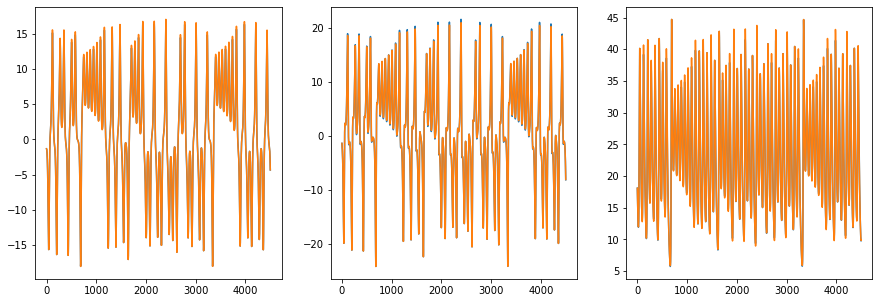

In [595]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axs[i]
    ax.plot(y_test[:, i])
    ax.plot(y_test_pred[:, i])

[0.71243533 0.19759869]
[499.71109667 263.17116446]


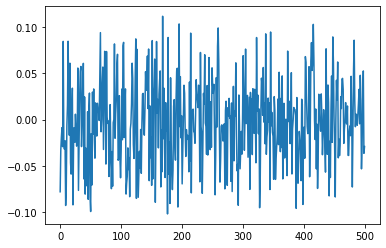

In [583]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(results_res)
# pca.fit(results_L96)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

pca1 = pca.components_[0]
plt.plot(pca1)

# KS iterator:


In [ ]:
dims = 200
L = 100

def data_creation_function_ks(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("kuramoto_sivashinsky_custom", dt, time_steps, starting_point, fft_type="scipy", dimensions=dims, system_size=L)

dt_ks = 0.5
def f_ks(x):
    return data_creation_function_ks(2, dt_ks, x)[-1]

In [ ]:
# test KS iterator:
time_steps = 1000
results_ks = np.zeros((time_steps, dims))

# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))

results_ks[0, :] = starting_point
for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    results_ks[i, :] = f_ks(x_last)

plt.imshow(results_ks.T, aspect="auto")

## Coupling of both systems:


In [0]:
w_in_scale = 0.0001
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))

In [0]:
# test KS iterator:
time_steps = 2000

# ks
results_ks = np.zeros((time_steps, dims))
# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))
results_ks[0, :] = starting_point

# lorenz:
results = np.zeros((time_steps, 3))
results[0, :] = np.array([0, 1, 0])

for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    x_last_in = results[i-1, :]
    x_add = w_in.dot(x_last_in)
    # if i > 1000:
    #     x_add = 0
    results_ks[i, :] = f_ks(x_last + x_add)
    results[i, :] = f(x_last_in)
plt.imshow(results_ks.T, aspect="auto")

In [ ]:
plt.plot(results[:, 0], results[:, 1], linewidth=0.1)
